In [1]:
#built in librairies 
from tqdm import tqdm

# pip libraires
import numpy as np
import json
import pandas as pd


# visualization librairies
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns

# Natural Language Processing Librairies
import nltk
from nltk.stem import LancasterStemmer
from nltk.tokenize import word_tokenize
import re

# Visualization librairies
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

#Calculating libraries
import scipy as sp

#statistical librairies
import pingouin 

# Import libraries
import requests
from bs4 import BeautifulSoup
import pickle


#from genres import genre_wordsets
import csv
import datetime  
from dateutil.relativedelta import relativedelta
from utils.genres import additional_wordsets
from pandas_profiling import ProfileReport

In [3]:
"""read table tvtropes and process the data to get rid of json format
"""
summaries=pd.read_csv('./data/plot_summaries.txt',sep="\t",header=None)
summaries.rename(columns={0:'wikipedia_movie_id',1:'Plot_summaries'},inplace=True)
movies=pd.read_table('./data/movie.metadata.tsv',header=None)
movies.rename(columns={0:'wikipedia_movie_id',1:'rebase_movie_ID',2:'Movie_name',3:'Movie_release',4:'Box_office_revenue',5:'Movie_runtime',6:'Movie_language',7:'Movie_country',8:'Movie_genre'},inplace=True)

df_summaries = pd.merge(summaries, movies[['wikipedia_movie_id', 'Movie_name']], on='wikipedia_movie_id')
pd.set_option('max_colwidth', 200)

,wikipedia_movie_id,rebase_movie_ID,Movie_name,Movie_release,Box_office_revenue,Movie_runtime,Movie_language,Movie_country,Movie_genre
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science Fiction"", ""/m/03npn"": ""Horror"", ""/m/03k9fj"": ""Adventure"", ""/m/0fdjb"": ""Supernatural"", ""/m/02kdv5l"": ""Action"", ""/m/09zvmj"": ""Space western""}"
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey Mystery,2000-02-16,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biographical film"", ""/m/07s9rl0"": ""Drama"", ""/m/0hj3n01"": ""Crime Drama""}"
2,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""Drama""}"
3,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic thriller"", ""/m/09blyk"": ""Psychological thriller""}"
4,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}"


In [7]:
from ast import literal_eval

final_df = pd.read_csv('data/country_sentiment_stitch.csv', index_col=0)
final_df[['who','where','country','sentiment']] = final_df[['who','where','country','sentiment']].applymap(literal_eval)
print(len(final_df))
final_df[-10:]

42204


,wikipedia_movie_id,Plot_summaries,Movie_name,who,where,country,sentiment
42194,871575,"{{Plot}} In an alternate universe, people are...",Avalon,"{'Sister': {'neg': 0.0, 'neu': 0.81, 'pos': 0....",{},{},"{'neg': 0.097, 'neu': 0.844, 'pos': 0.059, 'co..."
42195,17208834,A high school prom in Georgia is unexpectedly ...,Dance of the Dead,{},"{'Georgia': {'neg': 0.167, 'neu': 0.833, 'pos'...","{'United States': {'neg': 0.167, 'neu': 0.833,...","{'neg': 0.164, 'neu': 0.754, 'pos': 0.082, 'co..."
42196,29046736,Lucy is working as a dancer in a sleazy strip...,I Don't Want to Be Born,"{'Italian': {'neg': 0.0, 'neu': 0.783, 'pos': ...","{'Kensington': {'neg': 0.0, 'neu': 0.783, 'pos...","{'United Kingdom': {'neg': 0.1285, 'neu': 0.76...","{'neg': 0.158, 'neu': 0.771, 'pos': 0.071, 'co..."
42197,30352708,Twenty-something Eun-mo listens to a taxi driv...,Paju,"{'North Korean': {'neg': 0.148, 'neu': 0.852, ...","{'Paju': {'neg': 0.074, 'neu': 0.8714999999999...","{'South Korea': {'neg': 0.09866666666666667, '...","{'neg': 0.1, 'neu': 0.824, 'pos': 0.076, 'comp..."
42198,2867597,"An attempt to bring the famed ""Mr. Bill"" clay ...",Mr. Bill's Real Life Adventures,{},{},{},"{'neg': 0.045, 'neu': 0.819, 'pos': 0.136, 'co..."
42199,34808485,"The story is about Reema , a young Muslim scho...",Oomakkuyil Padumbol,"{'Muslim': {'neg': 0.0, 'neu': 0.804, 'pos': 0...","{'Malabar': {'neg': 0.0, 'neu': 0.804, 'pos': ...","{'United States': {'neg': 0.0, 'neu': 0.804, '...","{'neg': 0.063, 'neu': 0.85, 'pos': 0.087, 'com..."
42200,1096473,"In 1928 Hollywood, director Leo Andreyev look...",The Last Command,"{'Czarist': {'neg': 0.0, 'neu': 1.0, 'pos': 0....","{'Hollywood': {'neg': 0.09, 'neu': 0.909999999...","{'United States': {'neg': 0.09, 'neu': 0.90999...","{'neg': 0.09, 'neu': 0.783, 'pos': 0.127, 'com..."
42201,35102018,American Luthier focuses on Randy Parsons’ tra...,Randy Parsons: American Luthier,{},{},{},"{'neg': 0.0, 'neu': 0.82, 'pos': 0.18, 'compou..."
42202,8628195,"Abdur Rehman Khan , a middle-aged dry fruit se...",Kabuliwala,"{'Bengali': {'neg': 0.0, 'neu': 1.0, 'pos': 0....","{'Afghanistan': {'neg': 0.0, 'neu': 0.949, 'po...","{'Afghanistan': {'neg': 0.0, 'neu': 0.949, 'po...","{'neg': 0.069, 'neu': 0.828, 'pos': 0.104, 'co..."
42203,6040782,1940 - Operation Dynamo has just taken place. ...,Dad's Army,"{'French': {'neg': 0.0, 'neu': 0.859, 'pos': 0...","{'Dover': {'neg': 0.0, 'neu': 1.0, 'pos': 0.0,...","{'United Kingdom': {'neg': 0.0, 'neu': 0.96, '...","{'neg': 0.082, 'neu': 0.864, 'pos': 0.054, 'co..."


In [12]:
df_summaries = final_df
movies_copy = movies.copy()


movies_copy['Movie_release'] = pd.to_datetime(movies_copy['Movie_release'], errors = 'coerce').dt.year
df_summaries_dated = pd.merge(df_summaries, movies_copy[['wikipedia_movie_id', 'Movie_release', 'Movie_country', 'Movie_name']], on='wikipedia_movie_id')
df_summaries_dated['countries'] = df_summaries_dated['country'].apply(lambda x : list(x.keys()))
df_summaries_dated['where_key'] = df_summaries_dated['where'].apply(lambda x : str(list(x.keys())))
df_summaries_dated['country_sentiment'] = df_summaries_dated['country'].apply(lambda x : [list(dict(k).values())[3] for k in list(x.values())] if len(x.values()) else [])
df_summaries_dated['general_sentiment'] = df_summaries_dated['sentiment'].apply(lambda x : list(dict(x).values())[3])
df_summaries_dated['positive_sentiment'] = df_summaries_dated['sentiment'].apply(lambda x : list(dict(x).values())[2])
df_summaries_dated['negative_sentiment'] = df_summaries_dated['sentiment'].apply(lambda x : list(dict(x).values())[0])
df_summaries_dated['Movie_country'] = df_summaries_dated['Movie_country'].apply(lambda x : literal_eval(x).values())

df_summaries_dated = df_summaries_dated[['wikipedia_movie_id', 'Movie_name_y', 'Movie_country', 'Movie_release', 'countries', 'country_sentiment', 'where_key', 'general_sentiment', 'positive_sentiment', 'negative_sentiment']].sort_values(by=['Movie_release', 'wikipedia_movie_id'], ascending= False)

##
'''t = df_summaries_dated.copy()
t['c2'] = t['countries'].astype(str)
t = t.set_index(['wikipedia_movie_id', 'Movie_release', 'where_key', 'c2']).apply(pd.Series.explode).reset_index()
t = t[t['countries'] == 'Other']
t = t[t["Movie_release"] == 1984][['where_key', 'c2']]
print(t)'''

##

df_summaries_dated = df_summaries_dated.set_index(['wikipedia_movie_id', 'Movie_release', 'where_key', 'general_sentiment', 'Movie_country','Movie_name_y', 'positive_sentiment', 'negative_sentiment']).apply(pd.Series.explode).reset_index()

df_summaries_dated['production'] = 1
#print(df_summaries_dated.head(10))

In [13]:
df_summaries_dated

,wikipedia_movie_id,Movie_release,where_key,general_sentiment,Movie_country,Movie_name_y,positive_sentiment,negative_sentiment,countries,country_sentiment,production
0,36534974,2014.0,[],0.5994,(United States of America),Noah,0.111,0.059,NaN,NaN,1
1,37210334,2013.0,"['Osage County', 'Oklahoma']",-0.9485,(United States of America),August: Osage County,0.050,0.111,United States,0.0,1
2,36462620,2013.0,['Stalingrad'],-0.5956,(Russia),Stalingrad,0.077,0.102,Russia,0.0,1
3,36353947,2013.0,[],0.8885,(United States of America),Hell & Back,0.347,0.095,NaN,NaN,1
4,36353137,2013.0,['L.a.'],-0.9477,(),The Canyons,0.031,0.282,Philippines,-0.9477,1
...,...,...,...,...,...,...,...,...,...,...,...
26073,396398,NaN,"['Japan', 'Italy']",-0.9882,(),Witch Hunter Robin,0.028,0.103,Italy,0.0,1
26074,304789,NaN,[],-0.9943,(Japan),Mobile Suit Gundam 0080: War in the Pocket,0.080,0.217,NaN,NaN,1
26075,276762,NaN,[],-0.4215,(United States of America),Mickey's Revue,0.056,0.093,NaN,NaN,1
26076,235299,NaN,[],-0.9731,(United States of America),The Orphan's Benefit,0.066,0.108,NaN,NaN,1


In [14]:
movies_per_year = pd.DataFrame()
movies_per_year["count"] = movies_copy.groupby(['Movie_release']).wikipedia_movie_id.count()
print(movies_per_year)

#############

#mask = df_summaries_dated.Movie_country.apply(lambda x: 'China' in x)
#df_summaries_dated = df_summaries_dated[mask]

               count
Movie_release       
1888.0             1
1889.0             1
1890.0             2
1891.0             3
1892.0             3
...              ...
2012.0          1194
2013.0           164
2014.0            17
2015.0             4
2016.0             3

[129 rows x 1 columns]


['United States', 'United Kingdom', 'France', 'India', 'Other', 'Germany', 'Australia', 'Italy', 'China', 'Japan', 'Canada', 'Mexico', 'Spain', 'Russia', 'Romania', 'Vietnam', 'Netherlands', 'Austria', 'Luzon', 'Turkey', 'Switzerland', 'South Korea', 'Brazil', 'Poland', 'Sweden', 'Egypt', 'Israel', 'Argentina', 'Ireland', 'New Zealand']


<AxesSubplot:xlabel='Movie_release'>

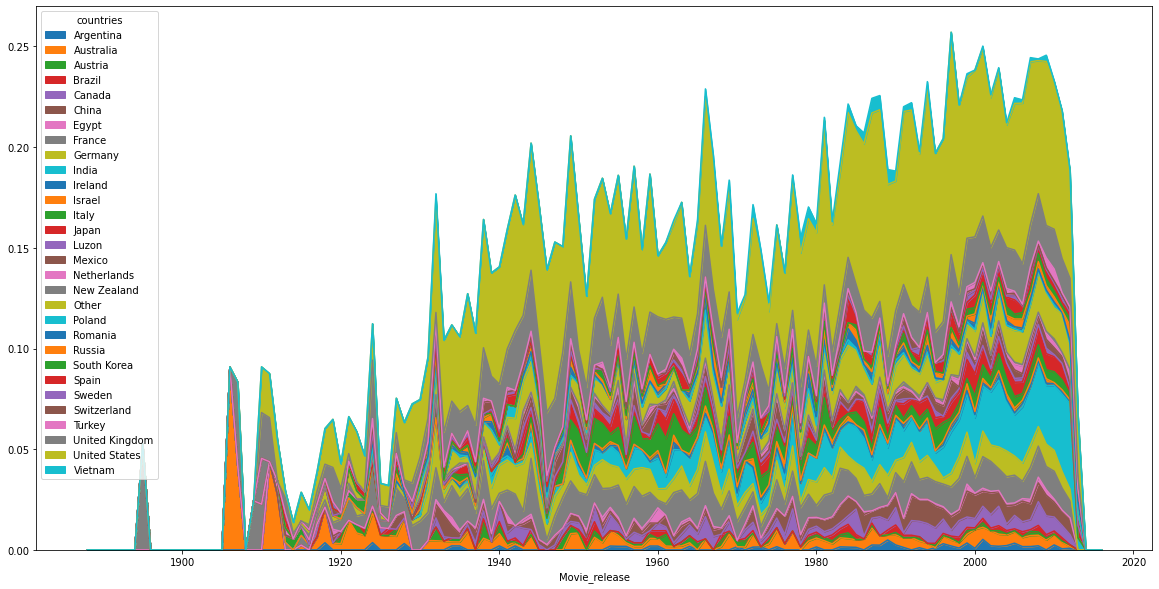

In [15]:
nbr_countries = 5

########
pt = pd.pivot_table(df_summaries_dated, columns=['countries'], index=['Movie_release'], values=['production'], aggfunc=np.sum)

pt = pt.divide(movies_per_year["count"], axis='index')

s = pt.sum(axis = 'index')
indx = list(s.sort_values(ascending=False).index[:nbr_countries].get_level_values('countries'))
print(indx)
pt.columns = pt.columns.get_level_values('countries')
pt = pt[np.intersect1d(pt.columns, indx)]

pt.fillna(0).plot.area(stacked=True, figsize=(20, 10))

<AxesSubplot:xlabel='Movie_release'>

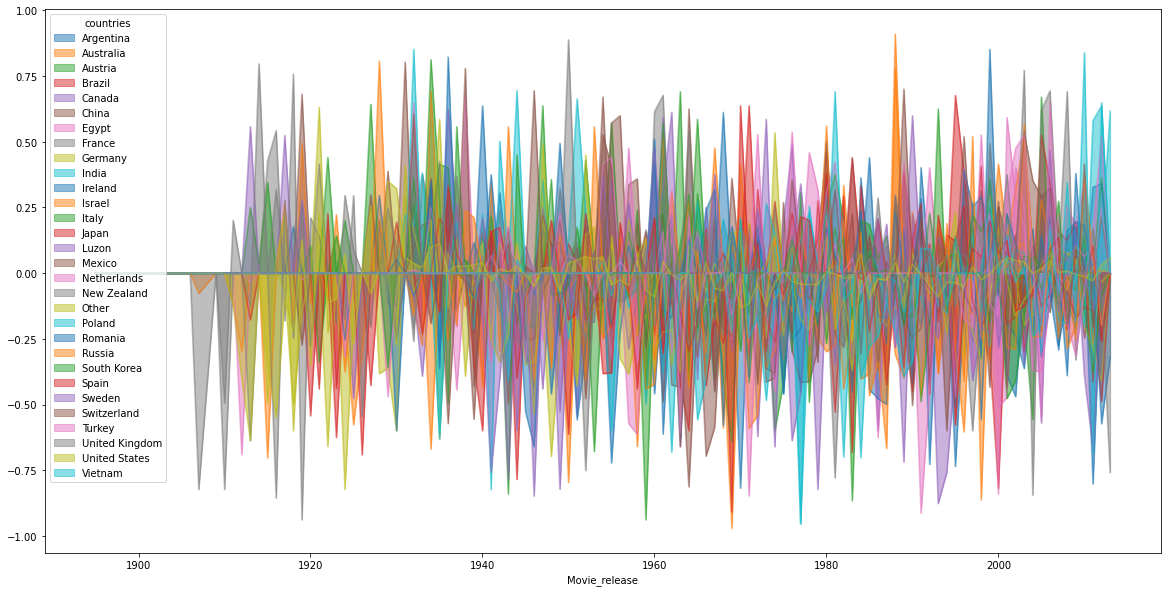

In [16]:
# split data into negative and positive values

pt1 = pd.pivot_table(df_summaries_dated, columns=['countries'], index=['Movie_release'], values=['country_sentiment'], aggfunc=np.mean)
pt1.columns = pt1.columns.get_level_values('countries')
pt1 = pt1[np.intersect1d(pt1.columns, indx)]

pt1.fillna(0).plot.area(stacked=False, figsize=(20, 10))

<AxesSubplot:xlabel='Movie_release'>

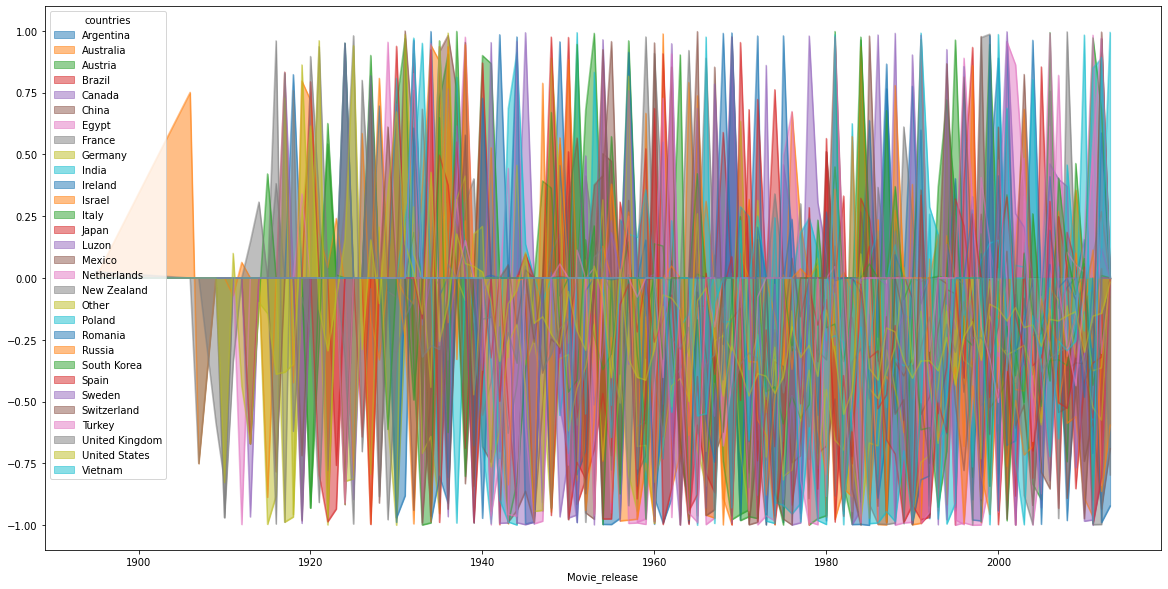

In [17]:
# split data into negative and positive values

pt1 = pd.pivot_table(df_summaries_dated, columns=['countries'], index=['Movie_release'], values=['general_sentiment'], aggfunc=np.mean)
pt1.columns = pt1.columns.get_level_values('countries')
pt1 = pt1[np.intersect1d(pt1.columns, indx)]

pt1.fillna(0).plot.area(stacked=False, figsize=(20, 10))

<AxesSubplot:xlabel='Movie_release'>

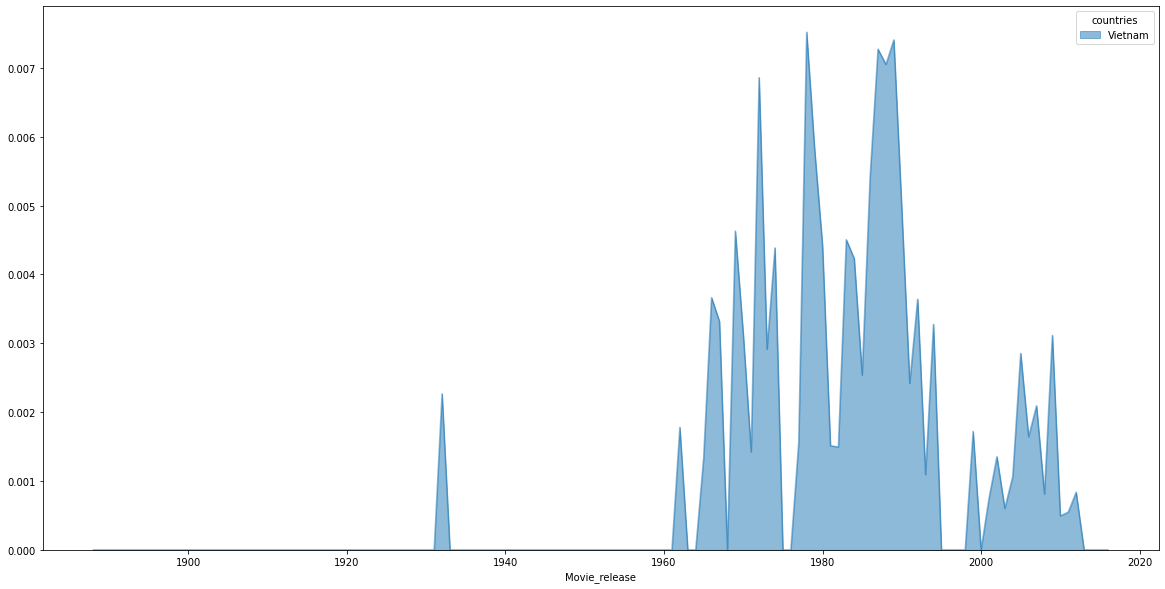

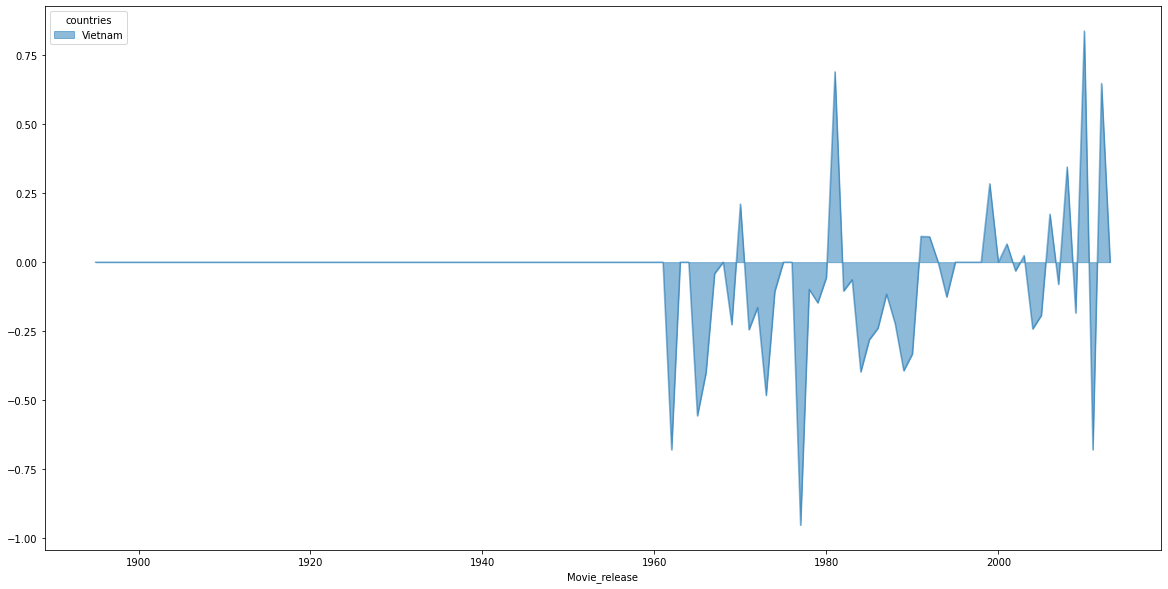

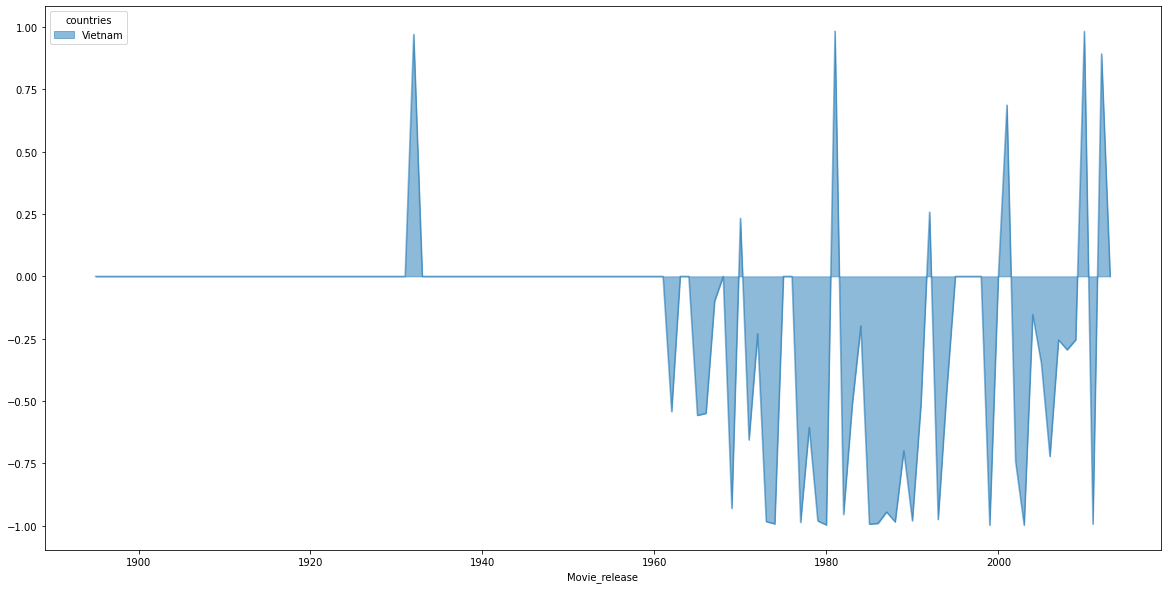

In [18]:
pt = pd.pivot_table(df_summaries_dated, columns=['countries'], index=['Movie_release'], values=['production'], aggfunc=np.sum)
pt1 = pd.pivot_table(df_summaries_dated, columns=['countries'], index=['Movie_release'], values=['country_sentiment'], aggfunc=np.mean)
pt2 = pd.pivot_table(df_summaries_dated, columns=['countries'], index=['Movie_release'], values=['general_sentiment'], aggfunc=np.mean)
pt.columns = pt.columns.get_level_values('countries')
pt1.columns = pt1.columns.get_level_values('countries')
pt2.columns = pt2.columns.get_level_values('countries')

pt = pt.divide(movies_per_year["count"], axis='index')

pt = pt[["Vietnam"]]
pt1 = pt1[["Vietnam"]]
pt2 = pt2[["Vietnam"]]

pt.fillna(0).plot.area(figsize=(20, 10), stacked=False)
pt1.fillna(0).plot.area(stacked=False, figsize=(20, 10))
pt2.fillna(0).plot.area(stacked=False, figsize=(20, 10))


In [19]:
sentiment_threshhold = 0.2

df_summaries_dated['pos'] = df_summaries_dated['general_sentiment'] > sentiment_threshhold
df_summaries_dated['neg'] = (-1)*(df_summaries_dated['general_sentiment'] < -sentiment_threshhold)

pt_pos = pd.pivot_table(df_summaries_dated, columns=['countries'], index=['Movie_release'], values=['pos'], aggfunc=np.sum)
pt_neg = pd.pivot_table(df_summaries_dated, columns=['countries'], index=['Movie_release'], values=['neg'], aggfunc=np.sum)
pt = pd.pivot_table(df_summaries_dated, columns=['countries'], index=['Movie_release'], values=['production'], aggfunc=np.sum)

pt_pos.columns = pt_pos.columns.get_level_values('countries')
pt_neg.columns = pt_neg.columns.get_level_values('countries')
pt.columns = pt.columns.get_level_values('countries')

pt_pos = pt_pos.divide(pt, axis='index').fillna(0)
pt_neg = pt_neg.divide(pt, axis='index').fillna(0)

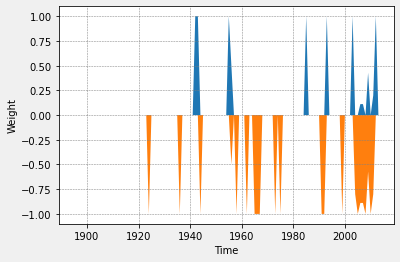

In [20]:
fig, ax = plt.subplots(nrows=1, ncols=1, facecolor="#F0F0F0")
ax.stackplot(pt_pos.index, pt_pos.Iraq)
ax.stackplot(pt_pos.index, pt_neg.Iraq)

ax.set_xlabel("Time")
ax.set_ylabel("Weight")
ax.grid(which="major", color="grey", linestyle="--", linewidth=0.5)

plt.show()

In [21]:
region_map = pd.read_csv('./data/country_regions.csv',sep=",", header=0)

In [22]:

location_region_map = pd.DataFrame(region_map['region'].unique(), columns =['region'])
location_region_map['address'] = location_region_map['region'].apply(geocode)
location_region_map['coordinates'] = location_region_map['address'].apply(lambda loc: tuple(loc.point) if loc else None)

In [23]:
location_country_map = pd.DataFrame(df_summaries_dated['countries'].unique(), columns =['countries'])
print(len(location_country_map))
location_country_map['address'] = location_country_map['countries'].apply(geocode)
location_country_map['coordinates'] = location_country_map['address'].apply(lambda loc: tuple(loc.point) if loc else None)

197


RateLimiter caught an error, retrying (0/2 tries). Called with (*('Liechtenstein',), **{}).
Traceback (most recent call last):
  File "c:\Users\nicte\AppData\Local\Programs\Python\Python39\lib\site-packages\urllib3\connectionpool.py", line 449, in _make_request
    six.raise_from(e, None)
  File "<string>", line 3, in raise_from
  File "c:\Users\nicte\AppData\Local\Programs\Python\Python39\lib\site-packages\urllib3\connectionpool.py", line 444, in _make_request
    httplib_response = conn.getresponse()
  File "c:\Users\nicte\AppData\Local\Programs\Python\Python39\lib\http\client.py", line 1377, in getresponse
    response.begin()
  File "c:\Users\nicte\AppData\Local\Programs\Python\Python39\lib\http\client.py", line 320, in begin
    version, status, reason = self._read_status()
  File "c:\Users\nicte\AppData\Local\Programs\Python\Python39\lib\http\client.py", line 281, in _read_status
    line = str(self.fp.readline(_MAXLINE + 1), "iso-8859-1")
  File "c:\Users\nicte\AppData\Local\Pro

In [24]:
location_country_map[['latitude', 'longitude', 'altitude']] = pd.DataFrame(location_country_map['coordinates'].tolist(), index=location_country_map.index)
location_country_map.latitude.isnull().sum()
location_country_map = location_country_map[pd.notnull(location_country_map['latitude'])]

df_summaries_coordinates = df_summaries_dated.copy()
df_summaries_coordinates = pd.merge(df_summaries_coordinates, location_country_map, on = 'countries')
print(df_summaries_coordinates.head(20))
print(location_country_map["countries"])

    wikipedia_movie_id  Movie_release where_key  general_sentiment  \
0             36534974         2014.0        []             0.5994   
1             36353947         2013.0        []             0.8885   
2             35938622         2013.0        []            -0.2500   
3             35854402         2013.0        []            -0.8689   
4             35815373         2013.0        []             0.7096   
5             35749085         2013.0        []             0.9601   
6             35720024         2013.0        []             0.4118   
7             35699958         2013.0        []            -0.5574   
8             35313233         2013.0        []            -0.9792   
9             35297009         2013.0        []             0.9195   
10            34711939         2013.0        []            -0.8213   
11            34707165         2013.0        []             0.0000   
12            34682342         2013.0        []            -0.8126   
13            346436

In [25]:
location_region_map[['latitude', 'longitude', 'altitude']] = pd.DataFrame(location_region_map['coordinates'].tolist(), index=location_region_map.index)
location_region_map.latitude.isnull().sum()
location_region_map = location_region_map[pd.notnull(location_region_map['latitude'])]
df_summaries_region = df_summaries_dated.copy()
df_summaries_region['region'] = df_summaries_region['countries'].map(region_map.set_index('countries')['region'])
#df_summaries_region['coordinates'] = df_summaries_region['region'].map(location_map.set_index('regions')['coordinates'])

df_summaries_region = pd.merge(df_summaries_region, location_region_map, on = 'region')
print(location_region_map["region"])
print(df_summaries_region)

0            Middle East
1           Soviet union
2                 Africa
3                Oceania
4                   PIGS
5          North America
6          Latin America
7     Continental Europe
8             South Asia
9        South East Asia
10             East Asia
11            North Asia
12           Scandinavia
Name: region, dtype: object
       wikipedia_movie_id  Movie_release  \
0                37210334         2013.0   
1                34907074         2013.0   
2                34004505         2013.0   
3                32910742         2013.0   
4                32427039         2013.0   
...                   ...            ...   
15587            12194848            NaN   
15588            11473235            NaN   
15589             7853164            NaN   
15590             7623911            NaN   
15591             2393755            NaN   

                                                                                                                      

In [26]:
df_summaries_region.to_csv('df_summaries_region.csv')

In [1]:
import pandas as pd
df_summaries_region = pd.read_csv('df_summaries_region.csv', index_col=0)

df_region_grouped = df_summaries_region.groupby(['Movie_release', 'region']).sum().reset_index()
df_region_grouped[['general_sentiment', 'pos', 'neg', 'positive_sentiment', 'negative_sentiment']] = \
    df_region_grouped[['general_sentiment', 'pos', 'neg', 'positive_sentiment', 'negative_sentiment']].div(df_region_grouped['production'], axis=0)

prod_by_year = df_region_grouped.groupby(['Movie_release']).sum().reset_index()
df_region_grouped['production'] /= df_region_grouped['Movie_release'].map(prod_by_year.set_index('Movie_release')['production'])

df_country_grouped = df_summaries_region.groupby(['Movie_release', 'countries']).sum().reset_index()
df_country_grouped[['general_sentiment', 'pos', 'neg', 'positive_sentiment', 'negative_sentiment']] = \
    df_country_grouped[['general_sentiment', 'pos', 'neg', 'positive_sentiment', 'negative_sentiment']].div(df_country_grouped['production'], axis=0)

df_country_grouped['production'] /= df_country_grouped['Movie_release'].map(prod_by_year.set_index('Movie_release')['production'])


In [2]:
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from jupyter_dash import JupyterDash
from dash import Dash, dcc, html, Input, Output, State

color_chart = px.colors.qualitative.Plotly

country_checklist = [['United States', 'United Kingdom', 'France', 'India', 'Germany', 'Australia', 'Italy', 'China', 'Japan', 'Canada', 'Mexico', 'Spain', 'Russia', 'Iraq', 'Vietnam', 'Netherlands', 'Austria', 'Luzon', 'Turkey', 'Switzerland', 'South Korea', 'Brazil', 'Poland', 'Sweden', 'Egypt', 'Israel', 'Argentina', 'Afghanistan', 'New Zealand'],
 ['Vietnam', 'Afghanistan', 'Iraq']]

region_checklist = [[
'Middle East',
'Soviet union',
'Africa',
'Oceania',
'PIGS',
'North America',
'Latin America',
'Continental Europe',
'South Asia',
'South East Asia',
'East Asia',
'North Asia',
'Scandinavia',], ['South Asia', 'Middle East', 'Continental Europe']]

app_areaplot = JupyterDash(__name__)

app_areaplot.layout = html.Div([
    html.H4("Country's key performance analytics"),
    html.P("Select country or region mode."),
    dcc.Dropdown(
        id='country_continent',
        options=['Country', 'Regions'],
        value='Country'
    ),
    html.P("Select desired countries.", id = "country_continent_text"),
    dcc.Checklist([],[],
      id='checklist',
      labelStyle={'display': 'block'},
      style={'columnCount': 7}
      ),
    html.P("Select sentiment or movie production analysis."),
    dcc.Dropdown(
        id='sentiment_prod',
        options=['Sentiment', 'Production'],
        value='Sentiment'
    ),
    dcc.Graph(id="graph"),
])

@app_areaplot.callback(
    [Output("checklist", 'options'),
    Output("checklist", 'value'),
    Output("country_continent_text", "children"), ],
    Input("country_continent", "value"))
def change_mode(contry_continent):
    if contry_continent == "Country":
        
        text = "Select desired countries."
        return country_checklist[0], country_checklist[1], text
    else :
        
        text = "Select desired regions."
        return region_checklist[0], region_checklist[1], text

@app_areaplot.callback(
    Output("graph", "figure"),  
    [Input("country_continent", "value"),
    Input("checklist", "value"),
    Input("sentiment_prod", "value")])
def display_area(contry_continent, checks, sentiment_prod):
    
    fig = make_subplots(specs=[[{"secondary_y": True}]])
    df = pd.DataFrame()
    
    if contry_continent == "Country":
        mode = "countries"
        df = df_country_grouped[df_country_grouped[mode].isin(checks)].fillna(0)
    else :
        mode = "region"
        df = df_region_grouped[df_region_grouped[mode].isin(checks)].fillna(0)

    if sentiment_prod == "Sentiment":
        axis_label = "Average positive(y>0) and negative(y<0) <br> sentiment score."
        for i, c in enumerate(checks):

            fig.add_trace(go.Scatter(
                name = c,
                x = df[df[mode] == c]["Movie_release"],
                y = df[df[mode] == c]["pos"],
                line_color= color_chart[i],
                fillcolor= color_chart[i],
                legendgroup= i,
                stackgroup='one',
            ))

            fig.add_trace(go.Scatter(
                name = c,
                x = df[df[mode] == c]["Movie_release"],
                y = df[df[mode] == c]["neg"],
                line_color= color_chart[i],
                fillcolor= color_chart[i],
                legendgroup= i,
                showlegend=False,
                stackgroup='two'
            ))
    else :
        axis_label = "Ratio of movies produced in a country <br> by total productions."
        for c in checks:

            fig.add_trace(go.Scatter(
                name = c,
                x = df[df[mode] == c]["Movie_release"],
                y = df[df[mode] == c]["production"],
                showlegend=True,
                legendgroup= 0,
                stackgroup='three'
            ))
    fig.update_layout(
    title="Evolution of movie " + str(sentiment_prod) + " by " + str(contry_continent),
    xaxis_title="Year",
    yaxis_title= axis_label,
    legend_title=str(contry_continent),
    )

    fig.add_hline(y=0, line_width=1, line_color="black")
    return fig


In [3]:
app_areaplot.run_server(mode = "external")

Dash app running on http://127.0.0.1:8050/


In [ ]:
import json

feature_collection = {
    'type': 'FeatureCollection',
    'features': []
}

# Loop through the rows of the DataFrame
for _, row in df_summaries_coordinates.iterrows():
    # Create a feature
    feature = {
        'type': 'Feature',
        'properties': {
            'time': row['Movie_release'],
            'description': row['countries'],
            'sentiment':row['general_sentiment'],
            'name': row['Movie_name_y'],
        },
        'geometry': {
            'type': 'Point',
            'coordinates': [row['longitude'], row['latitude']]
        }
    }

    # Add the feature to the feature collection
    feature_collection['features'].append(feature)

In [20]:
df_summaries_coordinates.to_csv('df_summaries_coordinates.csv')

In [1]:
import pandas as pd
df_summaries_coordinates = pd.read_csv('df_summaries_coordinates.csv', index_col=0)

In [2]:
import dash_leaflet as dl
import dash_leaflet.express as dlx
import plotly.express as px
from jupyter_dash import JupyterDash
from dash import Dash, dcc, html, Input, Output
from dash_extensions.javascript import assign
from dash.exceptions import PreventUpdate
import dash

slider_year = 2000
range_year = 1995

card_type = dl.TileLayer(
                            url='https://tiles.stadiamaps.com/tiles/alidade_smooth_dark/{z}/{x}/{y}{r}.png',
                            attribution='&copy; <a href="https://stadiamaps.com/">Stadia Maps</a>, &copy; <a href="https://openmaptiles.org/">OpenMapTiles</a> &copy; <a href="http://openstreetmap.org">OpenStreetMap</a> contributors',
                        )

df_summaries_coordinates = df_summaries_coordinates[df_summaries_coordinates['Movie_release'] >= 1900]
df_summaries_coordinates=df_summaries_coordinates.dropna(subset=['countries','latitude'])

colorscale = ['red', 'yellow', 'green']

chroma = "https://cdnjs.cloudflare.com/ajax/libs/chroma-js/2.1.0/chroma.min.js"  # js lib used for colors
color_prop = 'general_sentiment' # property to color by

# Create a colorbar.
vmax = 1
vmin = -1
colorbar = dl.Colorbar(colorscale=colorscale, width=20, height=150, min=-1, max=1, unit=' sentiment score', style= {'color': 'white'})


# Geojson rendering logic, must be JavaScript as it is executed in clientside.
point_to_layer = assign("""
function(feature, latlng, context){
    const {min, max, colorscale, circleOptions, colorProp} = context.props.hideout;
    const csc = chroma.scale(colorscale).domain([min, max]);  // chroma lib to construct colorscale
    circleOptions.fillColor = csc(feature.properties[colorProp]);  // set color based on color prop.
    return L.circleMarker(latlng, circleOptions);  // sender a simple circle marker.
}""")

cluster_to_layer = assign("""function(feature, latlng, index, context){
    const {min, max, colorscale, circleOptions, colorProp} = context.props.hideout;
    const csc = chroma.scale(colorscale).domain([min, max]);

    // Set color based on mean value of leaves.
    const leaves = index.getLeaves(feature.properties.cluster_id);
    let valueSum = 0;
    for (let i = 0; i < leaves.length; ++i) {
        valueSum += leaves[i].properties[colorProp]
    }
    const valueMean = valueSum / leaves.length;
    
    // Render a circle with the number of leaves written in the center.
    const icon = L.divIcon.scatter({
        html: '<div style="background-color:white;"><span>' + feature.properties.point_count_abbreviated + '</span></div>',
        className: "marker-cluster",
        iconSize: L.point(40, 40),
        color: csc(valueMean)
    });
    return L.marker(latlng, {icon : icon})
}""")

def get_data(subset):

    # Pre process the data into geobuf.
    dicts = subset.to_dict('rows')

    for row in dicts:
        row["tooltip"] = "{} ({:.1f})".format(str(int(row['Movie_release'])) + ',  ' + row['Movie_name_y'] + ' ', row[color_prop])  # bind tooltip

    geojson = dlx.dicts_to_geojson(dicts, lon="longitude", lat = "latitude")  # convert to geojson
    geobuf = dlx.geojson_to_geobuf(geojson)  # convert to geobuf

    # Create geojson.
    geojson = dl.GeoJSON(data=geobuf, id="geojson", format="geobuf",
                        zoomToBounds=True,  # when true, zooms to bounds when data changes
                        cluster=True,  # when true, data are clustered
                        clusterToLayer=cluster_to_layer,  # how to draw clusters
                        zoomToBoundsOnClick=True,  # when true, zooms to bounds of feature (e.g. cluster) on click
                        options=dict(pointToLayer=point_to_layer),  # how to draw points
                        superClusterOptions=dict(radius=120),   # adjust cluster size
                        hideout=dict(colorProp=color_prop, circleOptions=dict(fillOpacity=1, stroke=False, radius=5),
                                    min=vmin, max=vmax, colorscale=colorscale))

    return [card_type, geojson, colorbar]


In [3]:
# Create the app.
app = JupyterDash(external_scripts=[chroma], prevent_initial_callbacks=True)

##########################

map_layer = html.Div([

    dl.Map(get_data(df_summaries_coordinates[df_summaries_coordinates['Movie_release'].between(range_year, slider_year)]),

     id='world_map', zoom = 4, center=(40.0884, -3.68042)),

], style={'width': '100%', 'height': '80vh', 'margin': "auto", "display": "block", "position": "relative"})

app.layout = html.Div([
    html.P("Select Year Range to analyze the sentiment and filming location of the movies in those years."),

    dcc.Checklist(
    ['Fixed Range'],
    [],
    id='fixed_range',
    ),

    dcc.RangeSlider(min=1900, max=2015,
      step=1, value=[range_year, slider_year],
      marks={i: '{}'.format(i) for i in range(1900, 2015, 5)},
      tooltip={"placement": "bottom", "always_visible": True},
      id='range_slider',
    ),
      
      
    map_layer
])

range_difference = 5

@app.callback(
    [Output("world_map", "children"),
    Output("range_slider", "value")],

    [Input("range_slider", "value"),
    Input("fixed_range", "value")],)
def display_area(year_range, fixed_value):

    global slider_year
    global range_difference
    new_range = []

    if len(fixed_value) == 0 :
        range_difference = year_range[1] - year_range[0]
        return get_data(df_summaries_coordinates[df_summaries_coordinates['Movie_release'].between(year_range[0], year_range[1])]), [year_range[0], year_range[1]]

    else:
        if slider_year != year_range[0] :
            new_range = [year_range[0], year_range[0] + range_difference]
            slider_year = new_range[0]
            
        elif slider_year + range_difference != year_range[1] :
            new_range = [year_range[1] - range_difference, year_range[1]]
            slider_year = new_range[0]

        return get_data(df_summaries_coordinates[df_summaries_coordinates['Movie_release'].between(new_range[0], new_range[1])]), [new_range[0], new_range[1]]


C:\Users\nicte\AppData\Local\Temp/ipykernel_10688/4112677391.py:66: FutureWarning: Using short name for 'orient' is deprecated. Only the options: ('dict', list, 'series', 'split', 'records', 'index') will be used in a future version. Use one of the above to silence this warning.
  dicts = subset.to_dict('rows')


In [4]:
app.run_server(mode='inline', port=8050)